In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from itertools import chain
from manejo_datos import *
import re

/home/carlos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Modelo de Crédito
- Se desea predicir si un cliente permanecera al día con sus pagos dentro de los próximos 12 meses.
- Se tiene la información inicial de crédito con variables del cliente tales como: edad, ingresos, tipo de vivienda, estado civil, etc.
- Cada mes se reporta el estado de pago del cliente. 

![title](figures/model_structure.png)

In [2]:
predict_horizon = 12
maxlen = 61
dataSEG = pd.read_pickle('clean_data/moras.pkl', 'gzip')
dataOT  = pd.read_pickle('clean_data/otorgamiento.pkl', 'gzip')
obs_count =  dataSEG.count(axis=1)
dataSEG = dataSEG.loc[(obs_count>=predict_horizon)
                      &(obs_count<=maxlen+predict_horizon),:]
vars_to_drop = ['usuario_aprueba','analista_fc','analista_ori']
dataOT = dataOT.drop(vars_to_drop, axis = 1 )
dataOT, dataSEG = intersect_by_index(dataOT, dataSEG)

In [3]:
dataOT = dataOT.fillna(0)
scaler = StandardScaler()
scaler.fit(dataOT)

muSEG    =  np.nanmean(dataSEG.values)
sigmaSEG =  np.nanstd(dataSEG.values)
model_dict = {'scalerOT':scaler, 'featuresOT': dataOT.columns,
              'muSEG': muSEG, 'sigmaSEG': sigmaSEG, 'maxlen':maxlen}

In [4]:
dataSEG.head()

,2009-07-01,2009-08-01,2009-09-01,2009-10-01,2009-11-01,2009-12-01,2010-01-01,2010-02-01,2010-03-01,2010-04-01,...,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01
075MD1300502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005DI3800001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
052DI3600320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
052DI3600369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
052FNGM00227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dataOT.head()

,active_at_start,crcli_edad,crcli_estado_civil_B,crcli_estado_civil_C,crcli_estado_civil_D,crcli_estado_civil_P,crcli_estado_civil_S,crcli_estado_civil_V,crcli_neg_estrato_social,crcli_nivel_instruccion_N,...,crsol_tipo_desembolso_H,crsol_tipo_desembolso_N,crsol_tipo_prestamo_N,crsol_tipo_prestamo_P,crsol_tipo_prestamo_R,recurrencia,tipo_vivienda_Alquilada,tipo_vivienda_Familiar,tipo_vivienda_Hipotecaria,tipo_vivienda_Propia
075MD1300502,148549.0,46.572601,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
005DI3800001,84996.0,44.224659,0.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
052DI3600320,84996.0,24.224657,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
052DI3600369,84996.0,54.638355,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
052FNGM00227,84996.0,28.852055,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
X_OT, X_SEG = prepare_model_data(model_dict,
                                 dataOT, dataSEG, crop_tail=predict_horizon)
y = values_to_predict(dataSEG, maxlen, predict_horizon)

In [7]:
# np.concatenate([X_SEG[1,...], y[1,...]], axis=1)
# dataSEG.iloc[1,:].dropna()

In [8]:
# Random split
train_split = 0.85
idx       = np.random.permutation(X_SEG.shape[0])
idx_train = idx[0:int(train_split*X_SEG.shape[0])]
idx_val   = idx[int(train_split*X_SEG.shape[0]):]

X_train_SEG = X_SEG[idx_train,...]
y_train     = y[idx_train,...]

X_val_SEG   = X_SEG[idx_val,...]
y_val       = y[idx_val,...]

X_train_OT = X_OT[idx_train,:]
X_val_OT = X_OT[idx_val,:]
print('train size:', int(train_split*X_SEG.shape[0]))

train size: 358485


In [13]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input, concatenate, RepeatVector, Dropout
from keras.optimizers import sgd
from keras.callbacks import EarlyStopping


OT_input  = Input(shape = X_train_OT.shape[1:])
OT_dense1  = Dense(64,  activation = 'relu')(OT_input)
OT_dense2  = Dense(64,  activation = 'relu')(OT_dense1)

OT_dropout = Dropout(0.5)(OT_dense2)
OT_repeat = RepeatVector(maxlen)(OT_dropout)

SEG_input = Input(shape=(X_SEG.shape[1:]))
SEG_lstm   = LSTM(128, return_sequences = True, activation="relu")(SEG_input)

merge = concatenate([OT_repeat, SEG_lstm])
merge_dense = Dense(128, activation = 'relu')(merge)

dropout_merge = Dropout(0.5)(merge_dense)
final = Dense(1, activation = 'sigmoid')(dropout_merge)

model = Model(inputs=[OT_input, SEG_input], outputs=final)

opt = sgd(lr=0.01, decay=0.0001, momentum=0.5, nesterov=True)
callback = EarlyStopping(monitor='loss',min_delta=0.0001, patience=1, verbose=0, mode='auto')

model.compile(optimizer='adam', loss='binary_crossentropy', sample_weight_mode = 'temporal',
               metrics=['accuracy'])
num_epochs = 5
batch_size = 1024

model.fit([X_train_OT,X_train_SEG], y_train, batch_size=batch_size, sample_weight= X_train_SEG[...,1],
          epochs=num_epochs, verbose=1, callbacks=[callback])

Epoch 1/5
358485/358485 [==============================] - 26s 74us/step - loss: 0.4474 - acc: 0.9059
Epoch 2/5
358485/358485 [==============================] - 26s 73us/step - loss: 0.4010 - acc: 0.8777
Epoch 3/5
358485/358485 [==============================] - 27s 74us/step - loss: 0.3952 - acc: 0.8537
Epoch 4/5
358485/358485 [==============================] - 26s 73us/step - loss: 0.3910 - acc: 0.8413
Epoch 5/5
358485/358485 [==============================] - 26s 72us/step - loss: 0.3877 - acc: 0.8312


## Desempeño del modelo

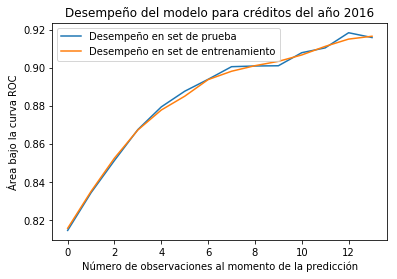

In [10]:
fig, ax = plt.subplots()
ax.set_title('Desempeño del modelo para créditos del año 2016')
ax.set_xlabel('Número de observaciones al momento de la predicción')
ax.set_ylabel('Área bajo la curva ROC')
roc_obs_train = [roc_at_obs(model, X_train_SEG, X_train_OT, y_train,
                            obs = obs) for obs in range(14)]
roc_obs_val =  [roc_at_obs(model, X_val_SEG, X_val_OT, y_val, obs = obs)
                  for obs in range(14)]
plt.plot(roc_obs_val, label   = 'Desempeño en set de prueba')
plt.plot(roc_obs_train, label = 'Desempeño en set de entrenamiento')
ax.legend()
plt.show()

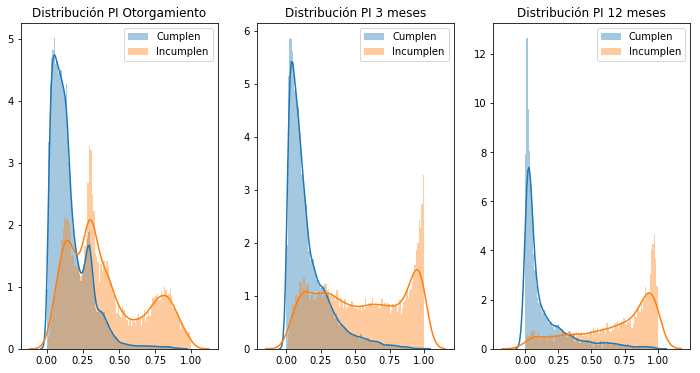

In [11]:
y_pred=model.predict([X_val_OT,X_val_SEG], batch_size=4096)

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,6))


sns.set_palette("Set2", 10)

obs = 0
ax1.set_title('Distribución PI Otorgamiento')
idx_pos, idx_neg = pos_neg_split(y_val, X_val_SEG, obs=obs)
sns.distplot(y_pred[idx_neg,obs,0], bins =100,ax=ax1)
sns.distplot(y_pred[idx_pos,obs,0], bins =100,ax=ax1)
ax1.legend(['Cumplen', 'Incumplen'])

obs = 3
ax2.set_title('Distribución PI 3 meses')
idx_pos, idx_neg = pos_neg_split(y_val, X_val_SEG, obs=obs)
sns.distplot(y_pred[idx_neg,obs,0], bins =100,ax=ax2)
sns.distplot(y_pred[idx_pos,obs,0], bins =100,ax=ax2)
ax2.legend(['Cumplen', 'Incumplen'])

obs = 12
ax3.set_title('Distribución PI 12 meses')
idx_pos, idx_neg = pos_neg_split(y_val, X_val_SEG, obs=obs)
sns.distplot(y_pred[idx_neg,obs,0], bins =100,ax=ax3)
sns.distplot(y_pred[idx_pos,obs,0], bins =100,ax=ax3)
ax3.legend(['Cumplen', 'Incumplen'])

plt.savefig('figures/distplot.pdf')
plt.show()

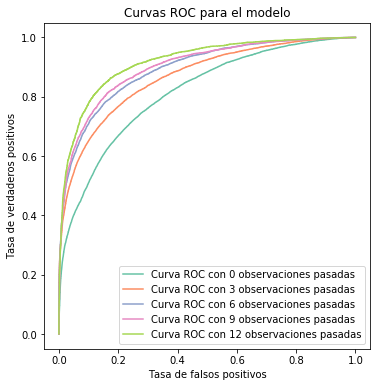

In [12]:
from sklearn.metrics import roc_curve
fig, ax = plt.subplots(figsize=(6,6))
for obs in np.arange(0,13,3):
    y_t, y_p = roc_at_obs(model, X_val_SEG, X_val_OT, y_val, obs = obs, return_roc=False)
    fpr, tpr, thresholds = roc_curve(y_t, y_p)
    ax.plot(fpr, tpr, label = 'Curva ROC con '+str(obs)+ ' observaciones pasadas')
ax.set_title('Curvas ROC para el modelo')
ax.legend()
ax.set_xlabel('Tasa de falsos positivos')
ax.set_ylabel('Tasa de verdaderos positivos')
ax.set_aspect(1)
#plt.savefig('figures/curvas_roc.pdf')
plt.show()

## Backtesting
![title](figures/backtesting.png)

### Modelo anterior de random Forests
![title](figures/BT.png)